In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Module, Sequential, Linear, Conv2d, ReLU, Tanh
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from models import U_Net

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 128
input_shape = (batch_size, 2, 32, 32)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

train_dataset.data = train_dataset.data[train_dataset.targets == 6]
train_dataset.targets = train_dataset.targets[train_dataset.targets == 6]

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
class v_model(Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape

        self.NN = U_Net(input_shape=input_shape, output_channels=1, initial_lr=0.01, momentum=0.9, weight_decay=0.)

    def forward(self, x_input, t):
        t = torch.ones_like(x_input) * t
        #print("t: ",t.shape)
        #print("x: ",x_input.shape)
        inputs = torch.stack([x_input, t], dim=2).reshape((x_input.shape[0], 2, 32,32 ))
        x = self.NN(inputs)

        return x

In [5]:
class RectifiedFlow(Module):
    def __init__(self, v_model):
        super().__init__()
        self.v_model = v_model.to(device)
        self.loss_curve = []

    def get_train_tuple(self, z0, z1):
        # random times
        t = torch.rand((z0.shape[0], 1)).to(device)
        t = t[:,:,None, None]
        # linear interpolation
        z_t = t* z1 + (1-t) * z0
        # connection line
        target = z1 - z0

        return z_t, t, target


    def sample_ode(self, z0, num_steps):
        trajectory = []
        trajectory.append(z0.detach().clone())

        batchsize = z0.shape[0]

        dt = 1./num_steps
        z = z0.detach().clone()
        for i in range(num_steps):
            t = torch.ones((batchsize, 1)).to(device) * i /num_steps
            t = t[:,:,None, None]
            #print(t.shape)
            pred = self.v_model(z, t)
            z = z.detach().clone() + pred * dt

            trajectory.append(z.detach().clone())

        return trajectory

In [6]:
def train_rectified_flow(rectified_flow, optimizer, train_dataloader, batchsize, epochs):
    loss_curve = rectified_flow.loss_curve
    for epoch in range(epochs):
        print("epoch: " , epoch)
        for batch in train_dataloader:
            if batch[1].shape[0] != batchsize:
                continue
            batch_target = batch[0].to(device)
            
            batch_init = torch.normal(torch.tensor(np.ones((batchsize,1, 32 , 32)) * 0.5), 1.0).float()
            batch_init = batch_init + torch.abs(torch.min(batch_init))
            batch_init = (255 * batch_init / torch.abs(torch.max(batch_init))).to(device)

            z_t, t, target = rectified_flow.get_train_tuple(batch_init, batch_target)

            pred = rectified_flow.v_model(z_t, t)
            loss = (target- pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
            loss = loss.mean()
            loss.backward()

            optimizer.step()
            loss_curve.append(loss.item())

    rectified_flow.loss_curve = loss_curve
    return rectified_flow, loss_curve

In [7]:
v_mod = v_model(input_shape)
rectified_flow_1 = RectifiedFlow(v_mod)

In [8]:
#rectified_flow_1 = torch.load("./models/MNIST_test5_2.pth")

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  9

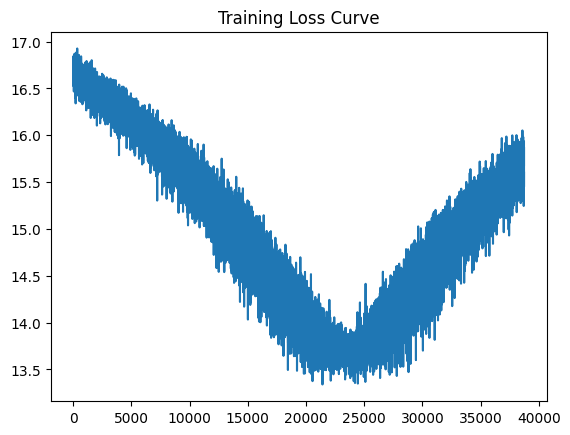

In [24]:
optimizer = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve_1 = train_rectified_flow(rectified_flow_1, optimizer, train_dataloader, batch_size, epochs=400)
torch.save(rectified_flow_1, "./models/MNIST_test5_2.pth")
rectified_flow_1_load = torch.load("./models/MNIST_test5_2.pth")
plt.plot(np.log(loss_curve_1))
plt.title("Training Loss Curve")
plt.show()

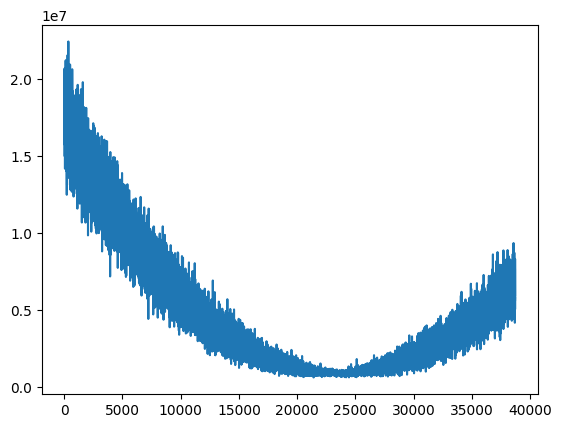

In [25]:
plt.plot(rectified_flow_1.loss_curve)

In [17]:
#rectified_flow_1 = torch.load("./models/MNIST_test5.pth")

In [26]:
batch_init = torch.normal(torch.tensor(np.ones((batch_size,1, 32 , 32)) * 0.5), 1.0).float()
batch_init = batch_init + torch.abs(torch.min(batch_init))
batch_init = (255 * batch_init / torch.abs(torch.max(batch_init))).to(device)

tensor([[119.5146,  83.7807, 143.4937,  ...,  74.8035, 105.6404, 142.8398],
        [168.8374, 145.0348, 136.8296,  ..., 127.4566,  29.5396, 151.4128],
        [138.0370,  75.5845, 145.5263,  ..., 157.1268, 100.8680, 141.5901],
        ...,
        [159.4089,  89.0529,  92.1377,  ...,  98.8085,  93.0946, 142.5833],
        [135.9985, 134.5665,  94.7165,  ..., 137.5273, 166.7511, 163.4883],
        [164.3091, 121.2995, 114.8395,  ..., 112.6049, 173.9474,  76.9644]],
       device='cuda:0')
tensor([[ -83.9593, -119.6931,  -59.9802,  ..., -128.6703,  -97.8335,
          -60.6340],
        [ -34.6365,  -58.4390,  -66.2660,  ...,  -76.0173, -173.4405,
          -52.0611],
        [ -65.4369, -127.8894,  -57.9476,  ...,  -46.3471, -102.6058,
          -61.8837],
        ...,
        [ -44.0649, -114.4209,  -90.4597,  ..., -104.6654, -107.7829,
          -60.8905],
        [ -67.4753,  -68.9074, -108.7573,  ...,  -65.9465,  -36.7227,
          -39.9855],
        [ -39.1647,  -82.1744,  -88.63

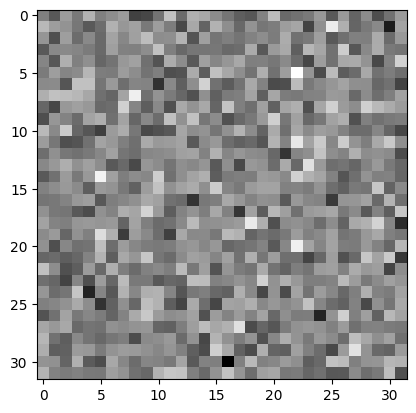

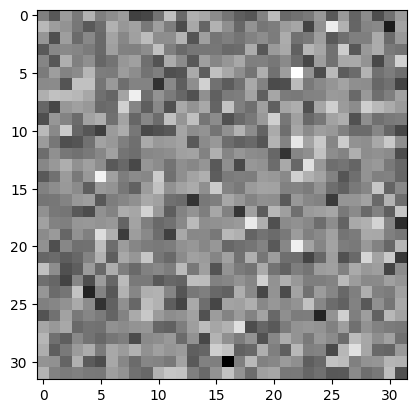

In [27]:
curr_img = 0
#print(batch_init.shape)
img = rectified_flow_1.sample_ode(batch_init[:2], 100)
print(batch_init[0, 0])
print(img[-1][curr_img].reshape(32,32))
plt.imshow(batch_init[0, 0].detach().cpu().numpy(), cmap="gray")
plt.show()
plt.imshow(img[-1][curr_img].reshape(32,32).detach().cpu().numpy(), cmap="gray")
plt.show()

In [14]:
v_mod_2 = v_model(input_dim, 784)
rectified_flow_2 = RectifiedFlow(v_mod_2)
flow_1 = rectified_flow_1.sample_ode(train_dataset_init, 100)
pairs_2 = torch.stack([train_dataset_init, flow_1[:][-1]], axis=1)

NameError: name 'input_dim' is not defined

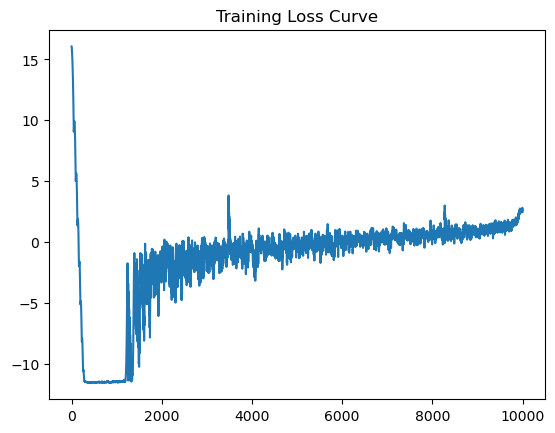

In [ ]:
optimizer = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)

rectified_flow_2, loss_curve_2 = train_rectified_flow(rectified_flow_2, optimizer, pairs_2, batch_size, inner_iters)
plt.plot(np.log(loss_curve_2))
plt.title("Training Loss Curve")
plt.show()

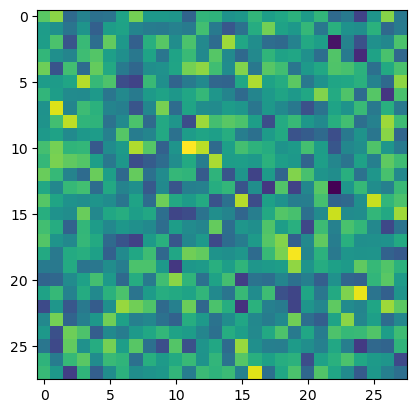

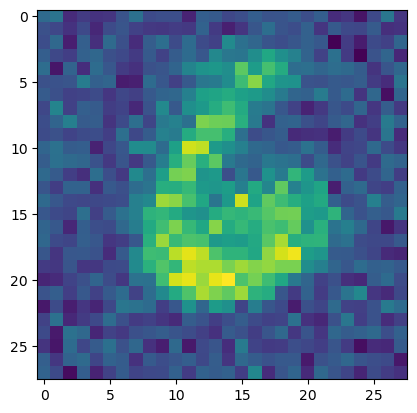

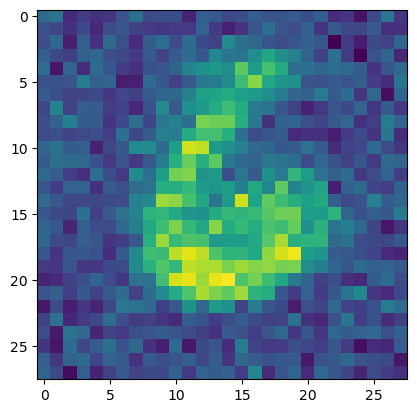

In [ ]:
curr_img = 0
img = rectified_flow_2.sample_ode(pairs_1[:100][0], 1)
plt.imshow(pairs_2[curr_img][0].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(pairs_2[curr_img][1].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(28,28).detach().cpu().numpy())

plt.show()

In [ ]:
del v_mod
torch.cuda.empty_cache()
v_mod_3 = v_model(input_dim, 784)
rectified_flow_3 = RectifiedFlow(v_mod_3)
flow_2 = rectified_flow_2.sample_ode(train_dataset_init, 100)
pairs_3 = torch.stack([train_dataset_init, flow_2[:][-1]], axis=1)

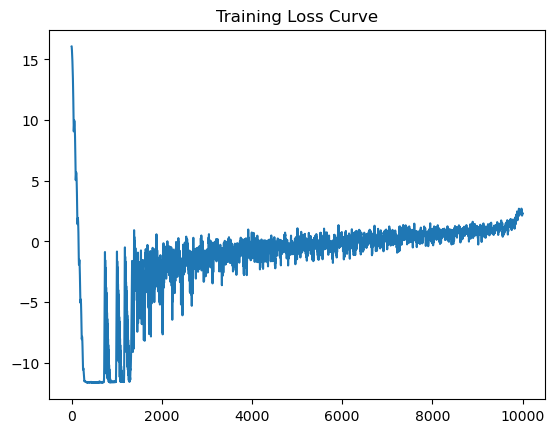

In [ ]:
optimizer = torch.optim.Adam(rectified_flow_3.v_model.parameters(), lr=5e-3)

rectified_flow_3, loss_curve_3 = train_rectified_flow(rectified_flow_3, optimizer, pairs_3, batch_size, inner_iters)
plt.plot(np.log(loss_curve_3))
plt.title("Training Loss Curve")
plt.show()

torch.Size([100, 784])


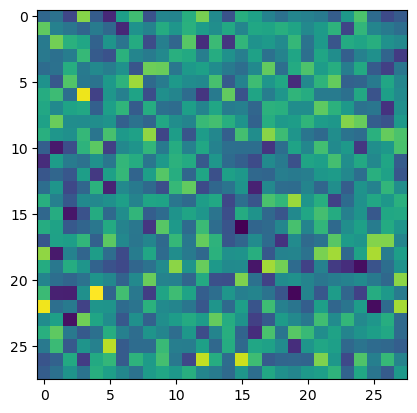

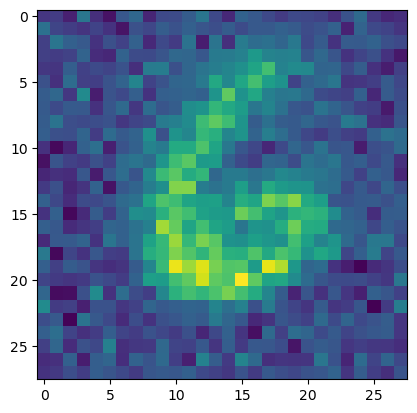

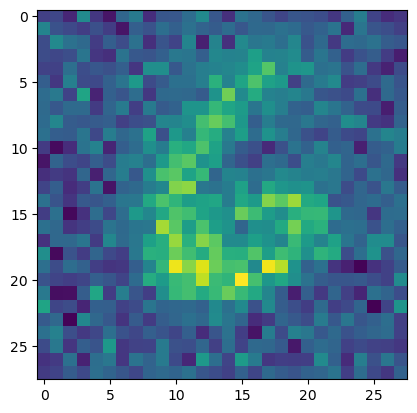

In [ ]:
curr_img = 30
img = rectified_flow_3.sample_ode(train_dataset_init[:100], 100)
print(img[-1].shape)
plt.imshow(train_dataset_init[curr_img].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(pairs_3[curr_img][1].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[70][curr_img].reshape(28,28).detach().cpu().numpy())

plt.show()